In [20]:
import numpy as np
import numpy.matlib
import seaborn as sns
import matplotlib.pyplot as plt
import math
import time
from sklearn.linear_model import Ridge
from random import randint

In [21]:
from keras.datasets import mnist

Given code
-----------


Part 1:
-----------
Generate a Mackey-Glass series for 4,000 time steps; n is in the range 
between 1 and 4,000. You have the Python function in 
“mackey_glass_gen.py”, which generates the time-series. Keep the 
default parameters for 

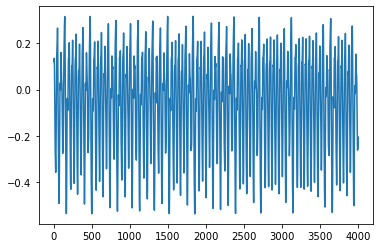

In [22]:

# check for intuition at  http://users.fs.cvut.cz/ivo.bukovsky/PVVR/prace_studentu/Mackey_Glass_time_series_prediction_Fuzzy_Lookup.pdf

def mackey_glass(tau, length):
    betta=0.2
    gamma = 0.1 
    a=10
    delay=100 # will cut these initial steps
    
    y=np.random.rand(tau) # random intial values between 0 and 1
    # Euler's method to solve the differential equation
    for t in range(tau-1, length+delay+tau-1):
        current= y[t] + ( betta * y[t-(tau-1)]   / ( 1 + np.power(y[t-(tau-1)], a) 
)  ) - gamma*y[t]   
        y=np.append(y, current)
    
    y=y-1 # get rid of mean
    y=np.tanh(y) # squeze with tanh    
    
    return y[tau+delay:length+delay+tau] # return the last length elements
length=4000 # duration of the series
tau=17 # delay in the equation
y=mackey_glass(tau, length)
#plot generated time-series
plt.plot(y)
plt.show()

part 2:
--------------
Take the first 3,000 steps for the training and leave the last 1,000 steps for the testing. 

In [23]:
def splitArrayTwo(array, firstLength):
    firstArray = array[:firstLength]
    secoundArray = array[firstLength:]
    firstArray = np.array(firstArray)
    secoundArray = np.array(secoundArray)
    return firstArray, secoundArray

train_Data , test_Data = splitArrayTwo(y,3000)
print(len(train_Data), len(test_Data))

3000 1000


Part 3:
------------
Fix the reservoir size to Nx = 1,000 neurons.

In [24]:
reservoirSize = 1000

Part 4:
---------
 Generate input weight matrix Win from uniform distribution between -1 
and 1. Scale Win by 0.2.

In [25]:
scale = 0.2
min_weight = -1
max_weight = 1
W_in = np.random.uniform(min_weight,max_weight,(reservoirSize,2))*scale

Part 5:
----------
Do not forget to add a bias input neuron, which constantly feeds 1 to the 
reservoir. 

In [26]:
bias = 1


Part 6: 
----------
 Set the spectral radius (feedback strength) for the reservoir connection 
matrix to ρ = 0.8. 

In [27]:
W_res = np.random.uniform(min_weight,max_weight,(reservoirSize,reservoirSize))*scale
spectralRadius  = 0.8
eg_val1 = np.abs(np.linalg.eigvals(W_res))
W_res = W_res/(max(eg_val1))*spectralRadius

Part 7 - 15:
--------


In [29]:
def training(training_set):
    W_out = np.random.uniform(-1,1,(1,(reservoirSize+1+1)))*scale
    #plot_weight_matrix(W_out, shape=[3,167])
    W_back = np.random.uniform(-1,1,(reservoirSize,1))*scale

    #Train network
    x = np.zeros(1000)
    y = np.zeros(1)
    X = []
    Y = []

    discard = 1000 # we descard due to the first values being contaminated by inital trransients
    ridgeRegretion = Ridge()
    
    for n in range(1,2998):
        #Varmstart
        u = np.array([training_set[n],bias])

        part1 = np.dot(W_res, x)
        part2 = np.dot(W_in,u)
        part3 = np.dot(W_back,np.array([training_set[n-1]]).real) #

        conc = np.concatenate([u, x])

        x = np.tanh(part1 + part2 + part3).real
        y = np.array(np.dot(W_out,conc).real)

        y_target = np.array([training_set[n+1]]).real
        X.append(conc)      # the value is inserted here for the traning so that we can prevenet overfitting.
        Y.append(y_target)

    X = X[discard:] 
    Y = Y[discard:]
    
    #from the reservoir using linear regression
    ridgeRegretion.fit(X,Y) # Fit Regression Model to describe the relationship between a set of predictors and a continuous response using the ordinary least squares method
    output = ridgeRegretion.coef_
    
    return x, y, output,W_back

def ESN(testing_set, x, y, W_out,W_res,W_in,W_back):
    Y = []
    error = []
    for n in range(len(testing_set)-1):
        #Varmstart
        u = np.array([testing_set[n],bias])

        part1 = np.dot(W_res, x)
        part2 = np.dot(W_in,u)
        part3 = np.dot(W_back,y)

        conc = np.concatenate([u, x])

        x = np.tanh(part1 + part2 + part3).real
        y = np.array(np.dot(W_out,conc).real)

        y_target = np.array([testing_set[n+1]]).real    
        Y.append(y)
        error.append(np.abs(y-y_target))    #minimizing the MSE between y(n) and y target(n);
    Y = np.array(Y)
    error = np.array(error)
    return(Y,error)


error_tot = []
y_tot = []
for i in range(10):
    x, y, output, W_back = training(train_Data)
    y_test_tot, error_test_tot = ESN(test_Data, x, y, output,W_res,W_in,W_back)
    y_tot.append(y_test_tot)
    error_tot.append(error_test_tot)

print("Mean Error", np.mean(error_tot))


Mean Error 0.16160332466555086


In [30]:
def plot_graph(target, output, output_color='black', target_color='red'):
    plt.subplots(figsize=(20,10))
    plt.plot(target, color=target_color, linewidth=4)
    plt.plot(output, color=output_color, linewidth=1.5)
    plt.show()

def error_graph(target, output, error_color='cyan', figsize=(20,10)):
    plt.subplots(figsize=figsize)

    error = np.abs(output - target)
    plt.plot(error, color=error_color)

    plt.show()

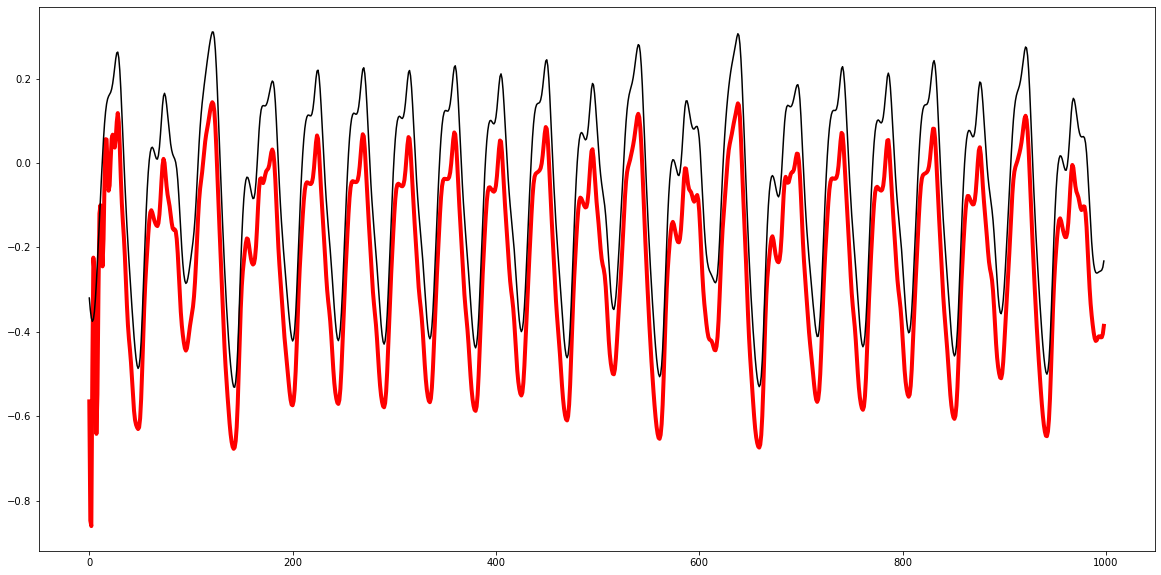

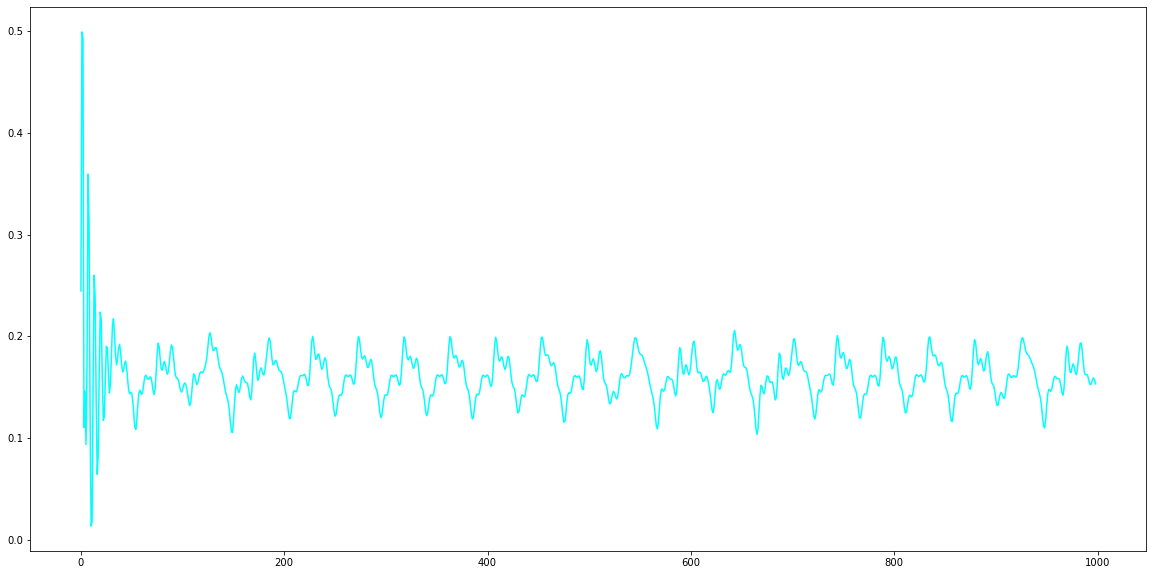

In [31]:
y_mean = np.mean(np.array(y_tot), axis=0)
plot_graph(y_mean, test_Data[:len(test_Data)-1])
error_graph(y_mean.flatten(), test_Data[:len(test_Data)-1])